In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from scipy import interpolate, stats
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d


In [25]:
data = pd.read_csv(r"C:\Users\Edwin\Downloads\test_df")
data = data.drop(data.index[0]) # drop dumb header

# pull data
pfh = pd.to_numeric(data['Component 3 wtf'] , errors='coerce')[:-1].tolist()
ethanol = pd.to_numeric(data['Component 4 wtf'] , errors='coerce')[:-1].tolist()
absorbance = pd.to_numeric(data['400.0nm'] , errors='coerce')[:-1].tolist()

In [3]:
def remove_visual_outliers(x, y, z, z_score_threshold = 3):
    """This is not a to remove statistical outliers, only to remove values which present. Outliers will be 
    removed based on the data of z and subsequently from x and y given the same indexes of entries. Inputs must be nparrays"""

    z_array = np.asarray(z)
    z_scores = np.abs(stats.zscore(np.asarray(z)))
    threshold = z_score_threshold
    index_to_remove = np.where(z_scores > threshold)[0] # must be in ascending order
    
    x = x.copy()
    y = y.copy()
    z = z.copy()
    
    for index in reversed(index_to_remove): # reveresed to perserve index
        del x[index]
        del y[index]
        del z[index]
    
    xyz_array = [x,y,z]
    return xyz_array


In [81]:
x=ethanol
y=pfh
z=absorbance
xyz=remove_visual_outliers(x,y,z,2)
x_out=xyz[0]
y_out=xyz[1]
z_out=xyz[2]

In [84]:
x_training = x
y_training = y
z_observation = z

xy_training = np.array([[x,y] for x,y in zip(x_training, y_training)])

kernal = kernal = C(1, (1e-1, 1e3)) * RBF(1, (1e-3, 1e3))
gp_model = GaussianProcessRegressor(kernel=kernal, n_restarts_optimizer=10, alpha=0.1, normalize_y=True) # random_state=42
gp_model.fit(xy_training, z_observation)

x_test = np.linspace(min(x_training), max(x_training)) # len = 50 default
y_test = np.linspace(min(y_training), max(y_training))
xy_test = np.asarray([x_test, y_test]).T # just getitng in (n, 2) as that was what fed to model
z_test_pred = gp_model.predict(xy_test) # this is single n

X,Y = np.meshgrid(x_test, y_test)
Z = np.reshape(z_test_pred,50)


ValueError: not enough values to unpack (expected 2, got 1)

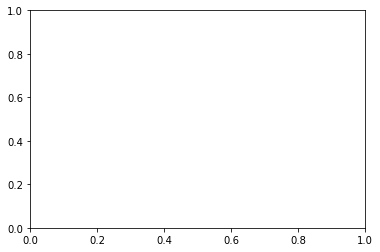

In [85]:
fig, ax = plt.subplots()

mappable = ax.pcolormesh(X,Y,Z, shading = 'gouraud')

In [55]:
t = np.array([[[1],[2],[3]], [[1],[2],[3]]])
t.shape
# t.sum(axis = 0)

(2, 3, 1)

In [61]:
t = np.array([1,2,3])
t1 = np.array([1,2,3])
np.asarray(list(product(t,t1))),np.meshgrid(t,t1)

(array([[1, 1],
        [1, 2],
        [1, 3],
        [2, 1],
        [2, 2],
        [2, 3],
        [3, 1],
        [3, 2],
        [3, 3]]),
 [array([[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]]),
  array([[1, 1, 1],
         [2, 2, 2],
         [3, 3, 3]])])

In [76]:
# here is where I am having the most trouble
x1_test = np.linspace(min(x1_training), max(x1_training)) # min to max range of the x1 values,linspace always amkes 50 requal spacing
x2_test = np.linspace(min(x2_training), max(x2_training))
x1x2 = np.array(list(product(x1_test, x2_test))) # this is not a mesh, just creation of more points
y_pred, MSE = gp_model.predict(x1x2, return_std=True) # find the interpolation of the mesh, my issue is that can we contain it, i dont like extrpolation

# so here they just reshaped a product they made to be a mesh so we can do the same
X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50) # grab the seperate meshes 
Zp = np.reshape(y_pred,(50,50))
y_pred.shape

(2500,)

In [8]:
y_pred_of_initial_training = gp_model.predict(x_training)
# y_pred_of_initial_training, y_observation # can compare these two, but should be plotting the obercation

0.04245938415007797


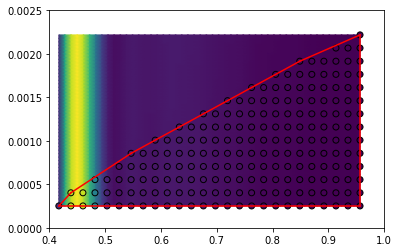

In [9]:
fig, ax = plt.subplots()
vmin = np.amin(Zp) # not sure 100 about where these vmin should come frm
vmax = np.amax(Zp)
print(vmin)
norm=colors.Normalize(vmin=vmin, vmax=vmax)
mappable = ax.pcolormesh(X0p, X1p, Zp, norm = norm, shading = 'gouraud')


ax.scatter(x_training[:,0], x_training[:,1], c = y_pred_of_initial_training, norm=norm, edgecolors='k') # scatter should be of the training data run through again
# # why is not being normlaized to the mesh grids interpolation? it should be, unless in the mesh grid there does not exist a colorfor that value!

plt.xlim([0.4,1])
plt.ylim([0,0.0025])
plt.xlabel('')
hull = ConvexHull(x_training)
for simplex in hull.simplices:
    plt.plot(x_training[simplex, 0], x_training[simplex, 1], 'r-')

In [ ]:
# undertsand what is being fed into pcolormesg
x1x2.shape
x = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([2, 3, 4, 5, 6, 7,5])
X,Y = np.meshgrid(x,y) 
# if the 1d array is n dimension then the meshgrid would be nxn,
# also the two x and y are dependent on each other for exdimension of Y is (y.shape, x.shape) as the entries in Y will be list which the list entries will match with a X point at teh level to make a point
y.shape, Y.shape

# lets use x1_test and x2_test, first we need to determine what points are in the hull, once we do just ocnvert it back, do product then reshape
# x1_true = []
# x2_true = []
# for x1,x2 in zip(x1_training,x2_training):
#     TF = point_in_hull([x1,x])

TF = np.asarray([point for point in x1x2 if point_in_hull(point,hull) == True])
x1x2 = TF
y_pred, MSE = gp_model.predict(x1x2, return_std=True) # find the interpolation of the mesh, my issue is that can we contain it, i dont like extrpolation

# so here they just reshaped a product they made to be a mesh so we can do the same
X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50) # grab the seperate meshes 
# Zp = np.reshape(y_pred,(50,50))

In [ ]:
def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)
point_in_hull([0.8,0.001],hull)

In [ ]:
points = x_training# 30 random points in 2-D
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [ ]:
np.random.rand(30, 2)

In [ ]:
[x,y